In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kartiknerwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kartiknerwal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/kartiknerwal/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/kartiknerwal/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kartiknerwal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
df = pd.read_csv('inputs/Reviews.csv')

In [4]:
df = df.head(500)

In [5]:
df['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [6]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Quick EDA

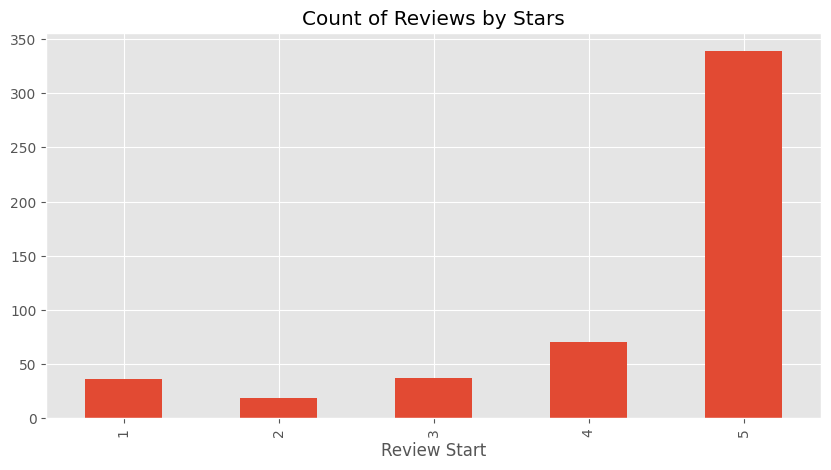

In [7]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title="Count of Reviews by Stars", figsize=(10,5))
ax.set_xlabel('Review Start')
plt.show()


### Basic nltk

In [8]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [9]:
import nltk

In [10]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [11]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [12]:
entities = nltk.chunk.ne_chunk(tagged_tokens=tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1: VADER Sentiment Scoring

###  a. Stop words are removed
###  b. Each word is scored and combined to a total score

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

In [14]:
sia = SentimentIntensityAnalyzer()

In [15]:
sia.polarity_scores('I am very much excited!')

{'neg': 0.0, 'neu': 0.502, 'pos': 0.498, 'compound': 0.4534}

In [16]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [17]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [18]:
# Run the polarity score ont he entire dataset
vader_res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    vader_res[myid] = sia.polarity_scores(text)
    

100%|██████████| 500/500 [00:00<00:00, 1847.84it/s]


In [19]:
vaders = pd.DataFrame(vader_res).T
vaders =vaders.reset_index().rename(columns = {'index':'Id'})
vaders = vaders.merge(df, how='left')

In [20]:
# We have sentiment score and metadata
vaders.head(2)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


### Step 2:
#### Plot Vader Results

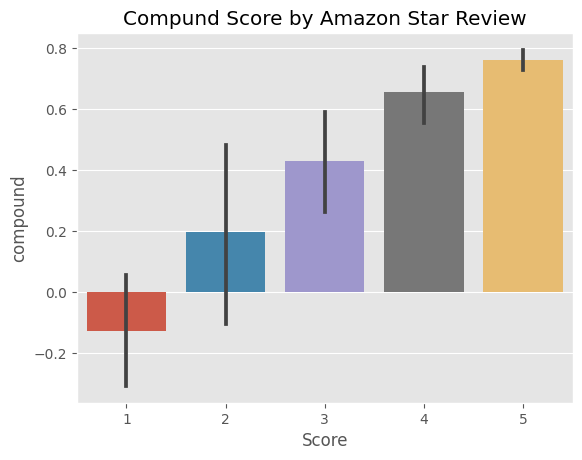

In [21]:
ax = sns.barplot(vaders, x='Score',y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

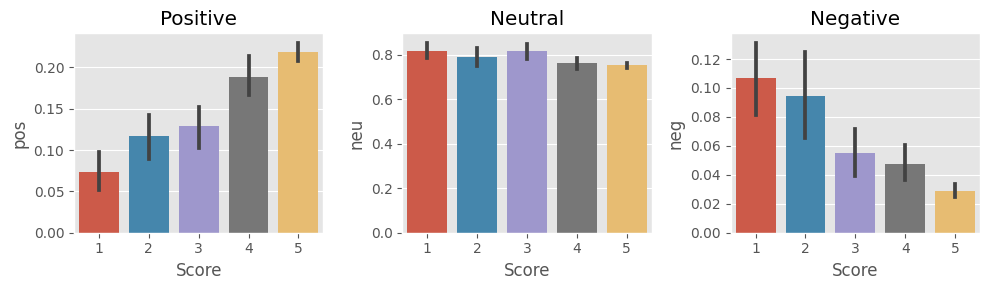

In [22]:
fig, axs = plt.subplots(1,3, figsize = (10,3))
sns.barplot(vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Step 3: Roberta Pretrained Model

##### * Use a model trained on a large corpus of data
##### * Transformer model accounts for the words but also the context related to other words

In [23]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

/Users/kartiknerwal/miniforge3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_new': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [27]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [28]:
# roberta_res = {}
# vader_res = {}
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_res = sia.polarity_scores(text)
        vader_res_rename = {}
        for key, value in vader_res.items():
            vader_res_rename[f"vader_{key}"] = value
        roberta_res = polarity_scores_roberta(text)
        both = {**vader_res_rename, **roberta_res}
        res[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")

 17%|█▋        | 85/500 [00:06<00:27, 15.35it/s]

Broke for id 83


 38%|███▊      | 188/500 [00:14<00:20, 15.49it/s]

Broke for id 187


100%|██████████| 500/500 [00:39<00:00, 12.63it/s]


In [29]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')
results_df.head(1)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_new,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.0,0.695,0.305,0.9441,0.010578,0.038816,0.950607,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [30]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_new', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
## Compare Scores b/w Models
sns.pairplot(results_df, 
             vars=['vader_neg', 'vader_neu', 'vader_pos',
            'roberta_neg', 'roberta_new', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## Step 4:
#### * Let's look at some examples where model scoring and review scoring differ the most


In [39]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [37]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [40]:
# Negative sentiment 5 stars review

In [44]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [45]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

## The Transformers Pipeline
##### * Quick & easy way to run sentiment predictions

In [46]:
from transformers import pipeline

In [50]:
sentiment_pipeline = pipeline("sentiment-analysis", model=MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
pipe_res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:    
        text = row['Text']
        myid = row['Id']
        pipe_res[myid] = sentiment_pipeline(text)
    except:
        continue

100%|██████████| 500/500 [00:31<00:00, 16.01it/s]


In [53]:
pipe_res

{1: [{'label': 'positive', 'score': 0.9506067037582397}],
 2: [{'label': 'negative', 'score': 0.7167685627937317}],
 3: [{'label': 'positive', 'score': 0.9169661402702332}],
 4: [{'label': 'positive', 'score': 0.9499569535255432}],
 5: [{'label': 'positive', 'score': 0.9861896634101868}],
 6: [{'label': 'positive', 'score': 0.9675799012184143}],
 7: [{'label': 'positive', 'score': 0.9815031290054321}],
 8: [{'label': 'positive', 'score': 0.9885830879211426}],
 9: [{'label': 'positive', 'score': 0.9395179152488708}],
 10: [{'label': 'positive', 'score': 0.962296187877655}],
 11: [{'label': 'positive', 'score': 0.9211084842681885}],
 12: [{'label': 'neutral', 'score': 0.5993607640266418}],
 13: [{'label': 'neutral', 'score': 0.4804050922393799}],
 14: [{'label': 'positive', 'score': 0.9902116656303406}],
 15: [{'label': 'positive', 'score': 0.9802030324935913}],
 16: [{'label': 'positive', 'score': 0.9819538593292236}],
 17: [{'label': 'positive', 'score': 0.9679679870605469}],
 18: [{'l